In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error 

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [4]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [5]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

In [6]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [7]:
train.columns

len(set(train.단지코드))

data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

data.shape

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

for i in sample.공급유형.unique():
    data[str(i)]=0

for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

data=data.fillna(0)

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

data=pd.merge(data, sample, on="단지코드", how="inner")

In [8]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

for i in sample.공급유형.unique():
    dat[str(i)]=0

for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수'] #전용면적별세대수
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

dat=dat.fillna(0)

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

dat=pd.merge(dat, sample, on="단지코드", how="inner")

dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',        '행복주택',        '영구임대',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',            '자격유형2',            '자격유형7',
                  '자격유형1',             '자격유형6',             '자격유형3',            '자격유형5',
             '대형전용면적']

data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',        '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',        '장기전세',        '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금',             '자격유형1',             '자격유형2',            '자격유형7',
                   '자격유형3',           '자격유형6',             '자격유형4',            '자격유형5',
            '대형전용면적']

147


In [10]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGB
from catboost import CatBoostRegressor

# Fitting
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGB
from catboost import CatBoostRegressor

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [11]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            #print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    #print(best_tst_idx)
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [12]:
train1=data[data.단지내주차면수<987].reset_index(drop=True)
train2=data[data.단지내주차면수>=987].reset_index(drop=True)
test1=dat[dat.단지내주차면수<987].reset_index(drop=True)
test2=dat[dat.단지내주차면수>=987].reset_index(drop=True)

print(train1.shape)
print(train2.shape)
print(test1.shape)
print(test2.shape)

(362, 49)
(52, 49)
(128, 46)
(19, 46)


In [13]:
# data load(group1)
X = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)
y = train1['등록차량수']
print(X.columns)
print(y.shape)

# fitting
# cv하고 싶으면 cv=True
# 특정 모델만 돌리고 싶으면 models 수정
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

best_model1, best_tst_pred1, best_error1 = fit_models(X, y, models, cv=True)
print('-------done-----------')
print(best_model1, best_error1)

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_울산광역시', '지역_전라남도',
       '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도'],
      dtype='object')
(362,)
-------done-----------
<catboost.core.CatBoostRegressor object at 0x00000167DE961430> 105.99285406297358


In [14]:
X = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)
y = train2['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

best_model2, best_tst_pred2, best_error2 = fit_models(X, y, models, cv=True)
print('-------done-----------')
print(best_model2, best_error2)

-------done-----------
<catboost.core.CatBoostRegressor object at 0x00000167DC8D32B0> 295.5874960747401


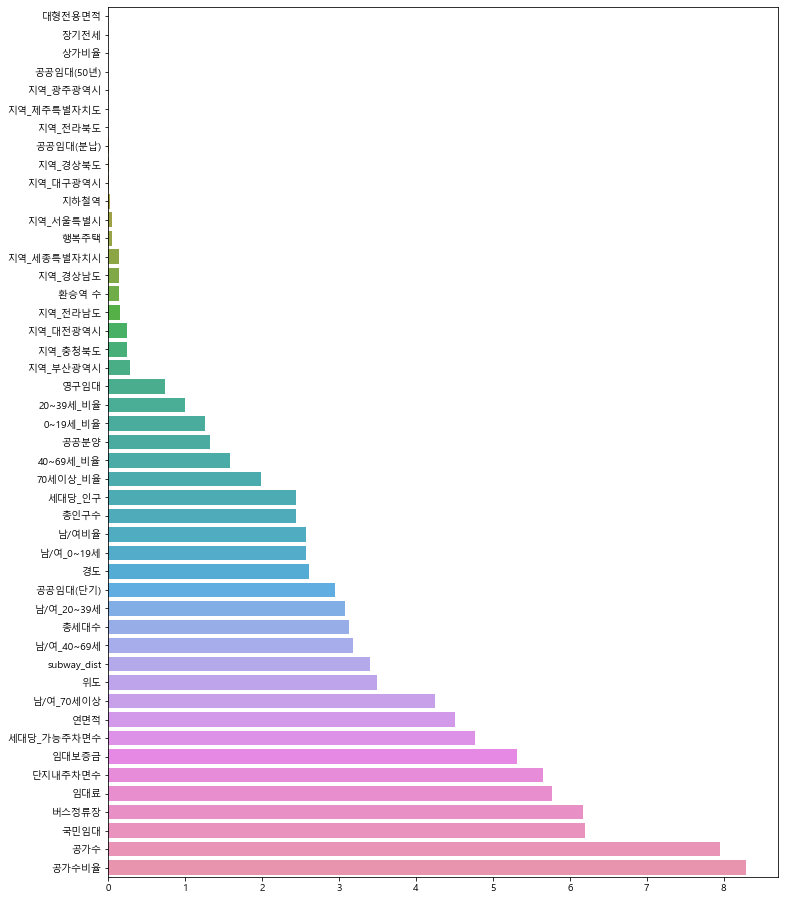

In [15]:
plt.figure(figsize=(12,16))
sns.barplot(y = X.columns[np.argsort(best_model2.feature_importances_)], x = list(best_model2.feature_importances_[np.argsort(best_model2.feature_importances_)]))

In [16]:
# 105 295

### 987보다 큰 범위

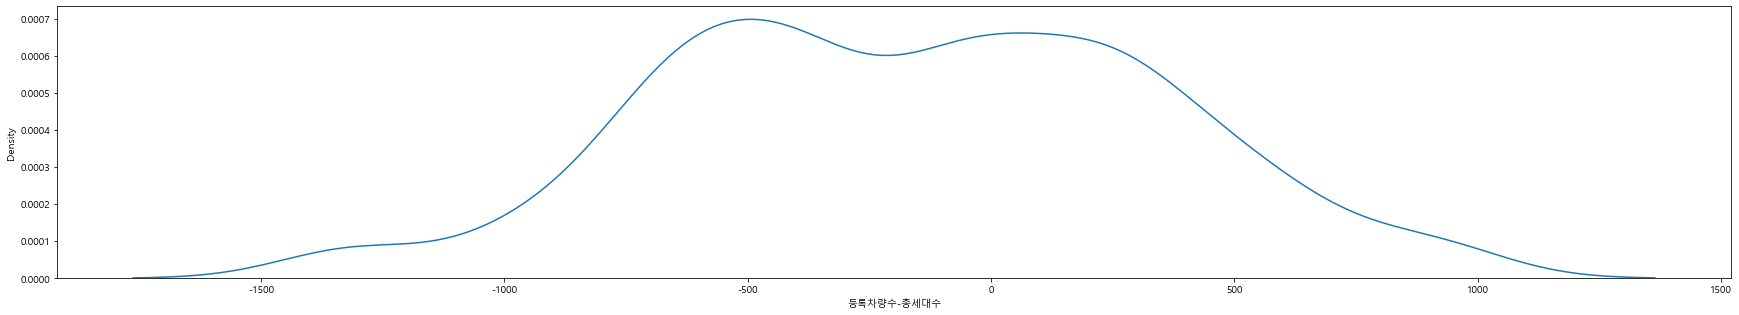

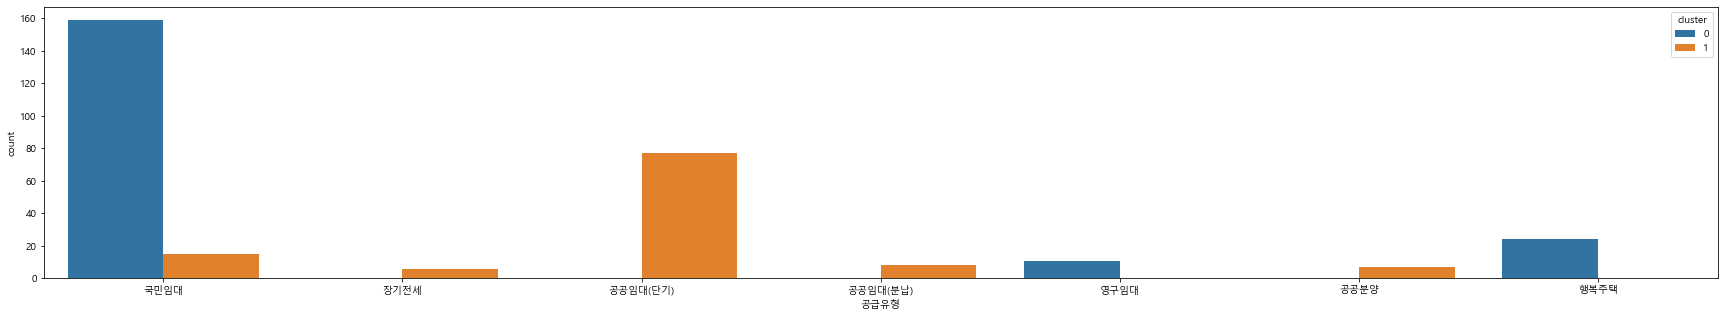

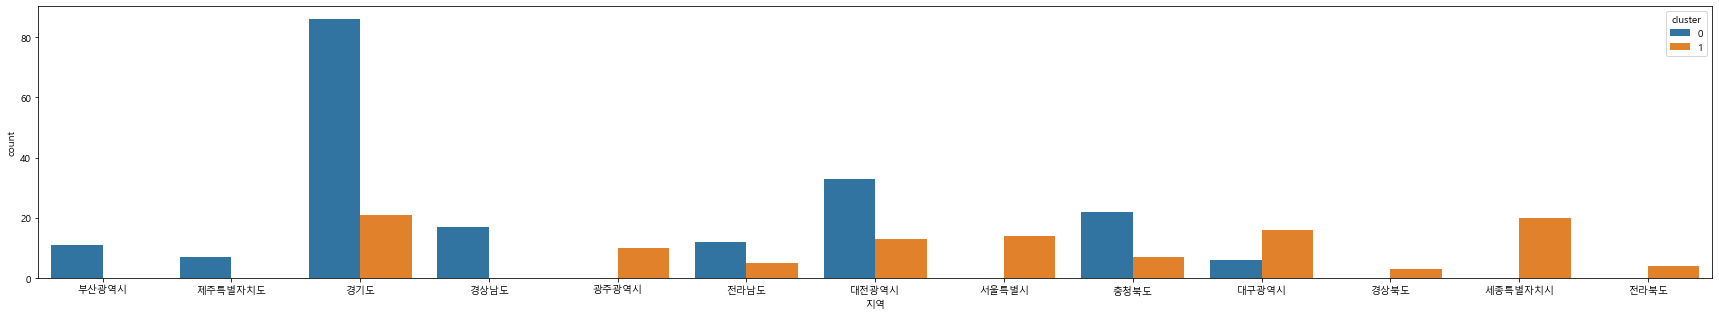

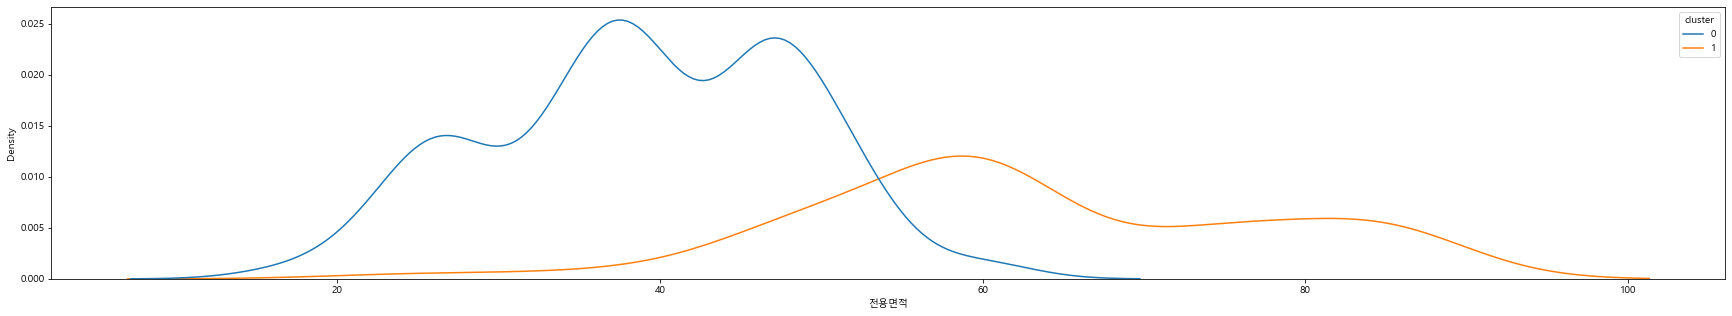

In [17]:
train = train[train['단지내주차면수']>=987].reset_index(drop=True)
test = test[test['단지내주차면수']>=987].reset_index(drop=True)

tmp=train.drop_duplicates(keep='first')
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]

tmp.columns

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='전용면적',hue='cluster')

In [18]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [19]:
train2['지역'] = train2['지역'].apply(lambda x : areafunc(x))
test2['지역'] = test2['지역'].apply(lambda x : areafunc(x))

In [20]:
train2 = train2.join(pd.get_dummies(train2['지역'],prefix='area')).iloc[:,:-1]
test2 = test2.join(pd.get_dummies(test2['지역'],prefix='area')).iloc[:,:-1]

In [21]:
train2.corr()['등록차량수']

총세대수           0.2821
지역             0.0849
공가수           -0.5594
지하철역           0.1353
버스정류장          0.3080
단지내주차면수        0.4263
등록차량수          1.0000
연면적            0.2449
위도            -0.2820
경도             0.0852
subway_dist   -0.1204
환승역 수          0.1185
총인구수          -0.2493
세대당_인구         0.2154
남/여비율         -0.2902
남/여_0~19세     -0.0878
남/여_20~39세    -0.2404
남/여_40~69세    -0.2025
남/여_70세이상     -0.0742
0~19세_비율       0.0171
20~39세_비율      0.0771
40~69세_비율     -0.0052
70세이상_비율      -0.1317
상가비율              nan
세대당_가능주차면수     0.1252
공가수비율         -0.5698
국민임대          -0.1136
영구임대           0.1492
임대상가              nan
공공임대(단기)       0.3687
장기전세           0.1189
행복주택          -0.1706
공공임대(분납)       0.2882
공공분양           0.3463
공공임대(50년)         nan
임대료            0.3720
임대보증금          0.3075
자격유형1          0.1465
자격유형2         -0.1513
자격유형7          0.3463
자격유형3          0.1578
자격유형6         -0.1677
자격유형4         -0.3231
자격유형5         -0.0047
대형전용면적            nan
area_0    

In [22]:
X = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7","지역","상가비율"]) 
y = train2['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

best_model2, best_tst_pred2, best_error2 = fit_models(X, y, models, cv=True)
print('-------done-----------')
print(best_model2, best_error2)

-------done-----------
<catboost.core.CatBoostRegressor object at 0x00000167DCC71460> 295.9342977834218


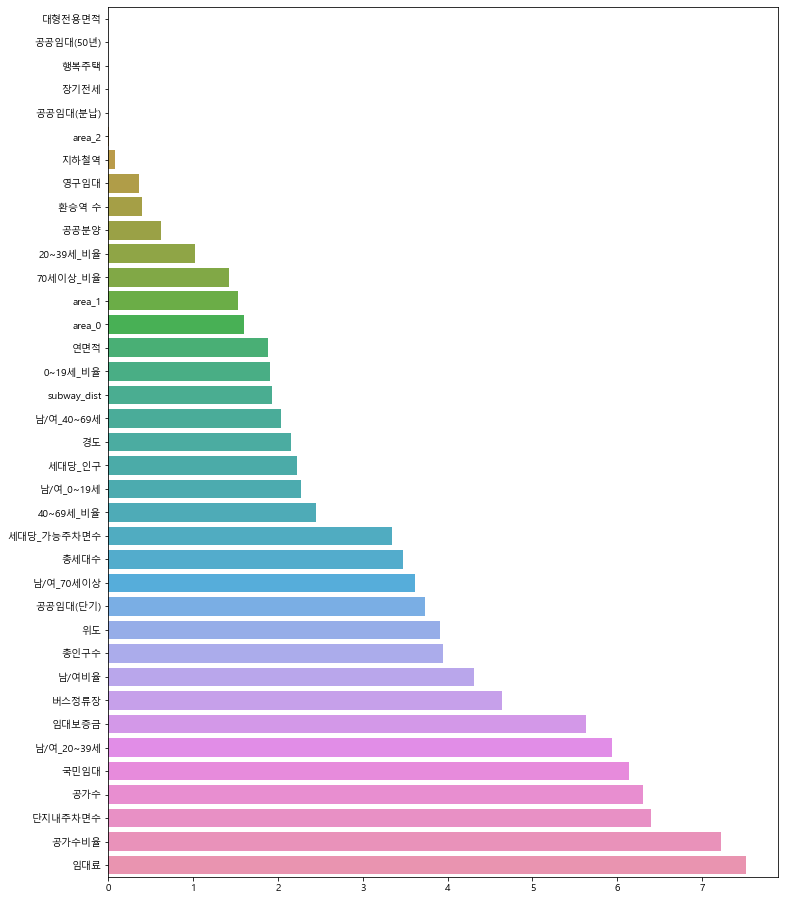

In [23]:
plt.figure(figsize=(12,16))
sns.barplot(y = X.columns[np.argsort(best_model2.feature_importances_)], x = list(best_model2.feature_importances_[np.argsort(best_model2.feature_importances_)]))

In [24]:
score = pd.read_csv("0720_f.csv")

In [25]:
X_train = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7","지역"]) 
y_train = train2['등록차량수']
X_test = test2.drop(columns=['단지명','단지코드','도로명주소','subway_name','임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7","지역"]) 
X_test['공공분양']=0
X_test['장기전세']=0

cb = CatBoostRegressor(random_state=2021, loss_function = 'MAE',verbose=False).fit(X_train,y_train)
pred = cb.predict(X_test)

In [26]:
pred2 = pd.DataFrame()
pred2['code'] = test2['단지코드'].values
pred2['num'] = pred

In [27]:
tmp = score.loc[score['code'].isin(test2['단지코드'].values),:]

In [28]:
res = pd.merge(tmp,pred2,on='code')

In [29]:
mean_absolute_error(res['num_x'],res['num_y'])

57.88915112111887

In [37]:
score = score.loc[-score['code'].isin(test2['단지코드'].values),:]
score = pd.concat([score,pred2],axis=0).reset_index(drop=True)

In [40]:
score.to_csv("put_area.csv",index=False)